##### Import required packages  


In [34]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import warnings
warnings.simplefilter('ignore',DeprecationWarning)
import seaborn as sns
import time
#import hdbscan

from sklearn.model_selection import ShuffleSplit
from sklearn.preprocessing import StandardScaler

#from sklearn.datasets import make_blobs

from sklearn.ensemble import RandomForestClassifier
from sklearn.calibration import CalibratedClassifierCV
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression

from sklearn import metrics
from sklearn import metrics as mt
from sklearn.metrics import log_loss
from sklearn.metrics import accuracy_score as acc
from sklearn.metrics import confusion_matrix as conf
from sklearn.metrics import f1_score, precision_score, recall_score, classification_report
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_recall_fscore_support as score

from tabulate import tabulate

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

#### - Overview of methodology  

 1 - set aside 20% of data set for final sacred test set  
 2 - split remaining 80% into train / test for grid search ??  
 3 - run grid search on each classification type  
     3.a. - search on range of model parameters and w/ cv = 5  
 4 - identify best accuracy / best parameters from grid search  
     4.a - run each classifier model w/ best params for later 10-fold CV verification
     4.b - use 80% of master_train data, 20% to verify results consistent with grid search model
 5 - run full 10-fold CV on the best model from each classifier - verify robustness  
    5.0 -   
    5.a - choose best overall model  
 6 - identify best overall model from the 4 classifiers after 10-fold CV 
 7 - run best overall model on original 20% sacred data set  
 8 - identify feature importance from each of the 4 classifier models (best model each)  
     8.a - maybe feature scale if needed for interpretation  
 9 - identify strengths / weakness of model prediction capability (e.g., some classes well predicted or not)  

#### Read in dataset from .csv file  

In [35]:
data_dir = '../data/'
data_file = 'OnlineNewsPopularity.csv'

file_2_read = data_dir + data_file
df = pd.read_csv(file_2_read)  

In [36]:
df.columns = df.columns.str.strip()
col_names = df.columns.values.tolist()

col_names

['url',
 'timedelta',
 'n_tokens_title',
 'n_tokens_content',
 'n_unique_tokens',
 'n_non_stop_words',
 'n_non_stop_unique_tokens',
 'num_hrefs',
 'num_self_hrefs',
 'num_imgs',
 'num_videos',
 'average_token_length',
 'num_keywords',
 'data_channel_is_lifestyle',
 'data_channel_is_entertainment',
 'data_channel_is_bus',
 'data_channel_is_socmed',
 'data_channel_is_tech',
 'data_channel_is_world',
 'kw_min_min',
 'kw_max_min',
 'kw_avg_min',
 'kw_min_max',
 'kw_max_max',
 'kw_avg_max',
 'kw_min_avg',
 'kw_max_avg',
 'kw_avg_avg',
 'self_reference_min_shares',
 'self_reference_max_shares',
 'self_reference_avg_sharess',
 'weekday_is_monday',
 'weekday_is_tuesday',
 'weekday_is_wednesday',
 'weekday_is_thursday',
 'weekday_is_friday',
 'weekday_is_saturday',
 'weekday_is_sunday',
 'is_weekend',
 'LDA_00',
 'LDA_01',
 'LDA_02',
 'LDA_03',
 'LDA_04',
 'global_subjectivity',
 'global_sentiment_polarity',
 'global_rate_positive_words',
 'global_rate_negative_words',
 'rate_positive_words',
 

# Data Preparation Part 1	
10	
Define and prepare your class variables. Use proper variable representations (int, float, one-hot, etc.). Use pre-processing methods (as needed) for dimensionality reduction, scaling, etc. Remove variables that are not needed/useful for the analysis.

### Task 2 data set definition  

 - For Task 2 classification we will classify the articles according to which data channel they are most likely to belong. The business case for this is to support directing the article to the data_channel most appropriate for the article content.  
 - In order to support this classification task, we create a new dependent variable column __data_channel__  which combines all of the individual binary boolean columns of __data_channel_is_xxx__ to __data_channel__ column with appropriate value  
 - We create 2 sets of this dependent variable, __data_channel__ and __data_channel_n__ . The only difference between these 2 columns is that __data_channel__ contains the text values for data channel category while the __data_channel_n__ contains an integer classifier (1 --> 7) which we associate to the text description in alphabetic order.  We create 2 versions of the column to be able to use the text version, when feasible, and the integer version in the case that that is required for a particular classifier routine.  
 - There are approx 15% of the articles which contain no identified __data_channel__ in the original data set. We create a new category, _Others_, for the articles without assignation to one of the standard data channels.  

In [37]:
# ... -=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=
# ... creating data_channel categorical variable
# ... -=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=

df['data_channel'] = 'Others'

condition = df['data_channel_is_lifestyle'] == 1
df.loc[condition, 'data_channel'] = 'Lifestyle'

condition = df['data_channel_is_entertainment'] == 1
df.loc[condition, 'data_channel'] = 'Entertainment'

condition = df['data_channel_is_bus'] == 1
df.loc[condition, 'data_channel'] = 'Business'

condition = df['data_channel_is_socmed'] == 1
df.loc[condition, 'data_channel'] = 'Social Media'

condition = df['data_channel_is_tech'] == 1
df.loc[condition, 'data_channel'] = 'Technology'

condition = df['data_channel_is_world'] == 1
df.loc[condition, 'data_channel'] = 'World'

del df['data_channel_is_lifestyle']
del df['data_channel_is_entertainment']
del df['data_channel_is_bus']
del df['data_channel_is_socmed']
del df['data_channel_is_tech']
del df['data_channel_is_world']


In [38]:
df.data_channel.value_counts()

World            8427
Technology       7346
Entertainment    7057
Business         6258
Others           6134
Social Media     2323
Lifestyle        2099
Name: data_channel, dtype: int64

In [39]:
# ... -=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=
# ... integer value of categorical values for multinomial NB classification
# ... -=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=

df['data_channel_n'] = 0

condition = df['data_channel'] == 'Business'
df.loc[condition, 'data_channel_n'] = 1

condition = df['data_channel'] == 'Entertainment'
df.loc[condition, 'data_channel_n'] = 2

condition = df['data_channel'] == 'Lifestyle'
df.loc[condition, 'data_channel_n'] = 3

condition = df['data_channel'] == 'Others'
df.loc[condition, 'data_channel_n'] = 4

condition = df['data_channel'] == 'Social Media'
df.loc[condition, 'data_channel_n'] = 5

condition = df['data_channel'] == 'Technology'
df.loc[condition, 'data_channel_n'] = 6

condition = df['data_channel'] == 'World'
df.loc[condition, 'data_channel_n'] = 7



In [40]:
df.data_channel_n.value_counts()

7    8427
6    7346
2    7057
1    6258
4    6134
5    2323
3    2099
Name: data_channel_n, dtype: int64


#### Delete __shares__ from the Task 2 data set  

__shares__ is the Task 1 dependent variable

we are excluding it from the Task 2 dataset as per the business model this value is not available during data_channel selection

The business model being developed here is that an article is proposed for publication, a set of text processing routines will extract and develop the model features from the raw article. The next step is to deploy the __data_channel__ assignment (classification) model, which is then also a necessary ingredient for the final model, Task 1, which is to estimate the __popularity__ of the article and thus provide recommendation to publish or not to publish.

Thus, for this Task 2 data set, we exclude the __shares__ data value.


In [41]:
# ... -=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=
# ...  shares is task 1 dependent variable
# ...  we are excluding it from this model as per business model this value is not available
# ...  during data_channel prediction
# ... -=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=

del df['shares'] 


In [42]:
del df['n_non_stop_words']
del df['n_non_stop_unique_tokens']
del df['n_unique_tokens']
del df['url']

In [43]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
timedelta,39644.0,354.530471,214.163767,8.00000,164.000000,339.000000,542.000000,731.000000
n_tokens_title,39644.0,10.398749,2.114037,2.00000,9.000000,10.000000,12.000000,23.000000
n_tokens_content,39644.0,546.514731,471.107508,0.00000,246.000000,409.000000,716.000000,8474.000000
num_hrefs,39644.0,10.883690,11.332017,0.00000,4.000000,8.000000,14.000000,304.000000
num_self_hrefs,39644.0,3.293638,3.855141,0.00000,1.000000,3.000000,4.000000,116.000000
num_imgs,39644.0,4.544143,8.309434,0.00000,1.000000,1.000000,4.000000,128.000000
num_videos,39644.0,1.249874,4.107855,0.00000,0.000000,0.000000,1.000000,91.000000
average_token_length,39644.0,4.548239,0.844406,0.00000,4.478404,4.664082,4.854839,8.041534
num_keywords,39644.0,7.223767,1.909130,1.00000,6.000000,7.000000,9.000000,10.000000
kw_min_min,39644.0,26.106801,69.633215,-1.00000,-1.000000,-1.000000,4.000000,377.000000


#### Assign certain variables to type integer, as appropriate

In [44]:
# ... -=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=
# ...  convert the data type to Integer
# ... -=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=

to_int = ['timedelta','n_tokens_title', 'n_tokens_content',
    'num_hrefs','num_self_hrefs', 'num_imgs', 'num_videos', 'num_keywords',
    'weekday_is_monday',
    'weekday_is_tuesday',
    'weekday_is_wednesday',
    'weekday_is_thursday',
    'weekday_is_friday',
    'weekday_is_saturday',
    'weekday_is_sunday',
    'is_weekend',
    'data_channel_n']
    

df[to_int] = df[to_int ].astype(np.int64)

In [45]:
df[df.duplicated()]

,timedelta,n_tokens_title,n_tokens_content,num_hrefs,num_self_hrefs,num_imgs,num_videos,average_token_length,num_keywords,kw_min_min,...,max_positive_polarity,avg_negative_polarity,min_negative_polarity,max_negative_polarity,title_subjectivity,title_sentiment_polarity,abs_title_subjectivity,abs_title_sentiment_polarity,data_channel,data_channel_n


#### Impute kw_avg_max for 0-values and re-scale to standard normal scale

 - A small number of rows have 0 value for __kw_avg_max__, which is completely out of range for the remaining rows of this variable.    
 - We will impute these rows to median value of the column  
 
 - The magnitude of this column of data is markedly different than the range of values in the remaining columns in the data set. To bring this back in line, we will re-scale the values in this column to standard normal range

In [46]:

# ... -=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=
# ...  impute to median value for a few rows of kw_avg_max
# ... -=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=

df.kw_avg_max.median()

condition = df['kw_avg_max'] == 0
df.loc[condition, 'kw_avg_max'] = df.kw_avg_max.median()

df.kw_avg_max.median()


# ... -=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=
# ...  scale to standard normal scale
# ... -=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=

#df.kw_avg_max.min()
#df.kw_avg_max.max()
#df.kw_avg_max.mean()
#df.kw_avg_max.std()

df.kw_avg_max = (df.kw_avg_max - df.kw_avg_max.mean()) / df.kw_avg_max.std()

#df.kw_avg_max.min()
#df.kw_avg_max.max()
#df.kw_avg_max.mean()
#df.kw_avg_max.std()


244572.22222250002

244575.00000025

#### Constant offset for variables with min value < 0  

 - This allows to consider these variables for ln() transform if highly right-skewed and also supports some classification models that only accept independent variables that are > 0  
 - Method here is to just add -1 * min_value of any column for which min_value < 0

In [47]:
# ... -=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=
# ...  for all columns with negative values, add +1 to all values in the column
# ...  - the only columns with negative values are polarity / sentiment measures
# ...  - adding a constant to all values does not modify distributions
# ... -=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=

df_numeric = df.select_dtypes(['number'])
numeric_col_names = df_numeric.columns.values.tolist()

# ... store min value for each column

df_mins = df.min()

# ... -=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=
# ...  loop on each column, test for min < 0, add constant as applicable
# ... -=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=

for column in numeric_col_names :
    if df_mins[column] < 0 :
        df[column] = df[column] - df_mins[column]
        
#        print('--> min_value < 0 adjusted : ', column, df_mins[column])

#### Ln() transform for variables that are right skewed (skewness > 1)  

 - This facilitiates maintaining more normally distributed residuals for regression models  
 - Likely, this will not be needed for the classification task, at present, but also does not have negative effects for this current activity


In [48]:
# ... -=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=
# ...  ln() transform right skewed distribution variables (skewness > 1)
# ... -=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=

df_numeric = df.select_dtypes(['number'])

numeric_col_names = df_numeric.columns.values.tolist()

# ... store min value for each column

df_mins = df.min()

# ... -=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=
# ...  loop on each column, test for skewness, create new column if conditions met
# ... -=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=

columns_to_drop = []

for column in numeric_col_names:
    sk = df[column].skew()
    
    if(sk > 1):
        new_col_name = 'ln_' + column
        print (column, sk, new_col_name)
        
        if df_mins[column] > 0:
            df[new_col_name] = np.log(df[column])
            columns_to_drop.append(column)
            
        elif df_mins[column] == 0:
            df_tmp = df[column] + 1
            df[new_col_name] = np.log(df_tmp)
            columns_to_drop.append(column)
            
        else:
            print('--> Ln() transform not completed -- skew > 1, but min value < 0 :', column, '!!')
            
            
# ... delete tmp data

del df_tmp
del df_mins
del df_numeric

# ... -=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=
# ...  based on inspection, a few of these are just not valid ranges in ln() space
# ...  -- just delete these few back out of the data set
# ... -=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=

print (columns_to_drop)

del df['ln_LDA_00']
del df['ln_LDA_01']
del df['ln_LDA_02']
del df['ln_LDA_03']
del df['ln_LDA_04']
columns_to_drop.remove('LDA_00')
columns_to_drop.remove('LDA_01')
columns_to_drop.remove('LDA_02')
columns_to_drop.remove('LDA_03')
columns_to_drop.remove('LDA_04')

# ...  these are binary indicators ... so no need to ln-transform

del df['ln_weekday_is_monday']
del df['ln_weekday_is_tuesday']
del df['ln_weekday_is_wednesday']
del df['ln_weekday_is_thursday']
del df['ln_weekday_is_friday']
del df['ln_weekday_is_saturday']
del df['ln_weekday_is_sunday']
del df['ln_is_weekend']
columns_to_drop.remove('is_weekend')
columns_to_drop.remove('weekday_is_monday')
columns_to_drop.remove('weekday_is_tuesday')
columns_to_drop.remove('weekday_is_wednesday')
columns_to_drop.remove('weekday_is_thursday')
columns_to_drop.remove('weekday_is_friday')
columns_to_drop.remove('weekday_is_saturday')
columns_to_drop.remove('weekday_is_sunday')

#columns_to_drop.remove('data_channel')

print ('\n-----------------------------------\n')
print ('Number of current columns in dataset :', len(df.columns))

df.drop(columns_to_drop, axis = 1, inplace = True)

#df.info()


n_tokens_content 2.94542193879 ln_n_tokens_content
num_hrefs 4.0134948282 ln_num_hrefs
num_self_hrefs 5.17275110576 ln_num_self_hrefs
num_imgs 3.94659584465 ln_num_imgs
num_videos 7.0195327863 ln_num_videos
kw_min_min 2.37494728018 ln_kw_min_min
kw_max_min 35.3284337312 ln_kw_max_min
kw_avg_min 31.3061081027 ln_kw_avg_min
kw_min_max 10.3863716348 ln_kw_min_max
kw_max_avg 16.4116695554 ln_kw_max_avg
kw_avg_avg 5.76017729162 ln_kw_avg_avg
self_reference_min_shares 26.2643641603 ln_self_reference_min_shares
self_reference_max_shares 13.8708490494 ln_self_reference_max_shares
self_reference_avg_sharess 17.9140933777 ln_self_reference_avg_sharess
weekday_is_monday 1.77590824423 ln_weekday_is_monday
weekday_is_tuesday 1.61054706191 ln_weekday_is_tuesday
weekday_is_wednesday 1.60097097689 ln_weekday_is_wednesday
weekday_is_thursday 1.6370700483 ln_weekday_is_thursday
weekday_is_friday 2.03030483518 ln_weekday_is_friday
weekday_is_saturday 3.63708575997 ln_weekday_is_saturday
weekday_is_sunday

# Data Preparation Part 2

#### Data Selection - Task 2 - data_channel classification

- There are 60 columns in the original data set; we added a few additonal columns based on observed opportunities (e.g., _publication_date_, ...) as explained above. 
    
- From this data set, we did a simple correlation matrix to look for variables that are highly correlated with each other that could be removed with little loss of information.

- With that downselection, we proceeded with additional evaluation of these remaining variables.
    
- we recognize that there is likely significant additional opportunity for modeling improvements with many of the remaining variables, and will look to re-expand the data set to further consider that with future work.  

In [49]:

# ... -=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=
# ... display highest correlation pairs from corr() matrix 
# ...
# ... https://stackoverflow.com/questions/17778394/list-highest-correlation-pairs-from-a-large-correlation-matrix-in-pandas
# ... -=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=

df_numeric = df.select_dtypes(['number'])

def get_redundant_pairs(df):
    '''Get diagonal and lower triangular pairs of correlation matrix'''
    pairs_to_drop = set()
    cols = df.columns
    for i in range(0, df.shape[1]):
        for j in range(0, i+1):
            pairs_to_drop.add((cols[i], cols[j]))
    return pairs_to_drop

def get_top_abs_correlations(df, n = 5):
    au_corr = df.corr().abs().unstack()
    labels_to_drop = get_redundant_pairs(df)
    au_corr = au_corr.drop(labels = labels_to_drop).sort_values(ascending = False)
    return au_corr[0:n]

# ... -=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=
# ... list out Top30 correlations
# ... -=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=

n_val = 30

top_30_corr_list = get_top_abs_correlations(df_numeric, n_val)
print("\n\n-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-")
print("Top Absolute Correlations\n")
print(top_30_corr_list)


icor = 0
drop_column = list()
while (top_30_corr_list[icor] > 0.65):
    drop_column.append(top_30_corr_list[top_30_corr_list == top_30_corr_list[icor]].index[0][0])
    icor += 1

drop_column = list(set(drop_column))

print("\n\n-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-")
print("Columns Recommended for removal based on correlation > 0.65")
print("-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-\n")

print("\n".join(sorted(drop_column)))

# ... -=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=
# ... drop one of the high correlation columns (2nd of the pair)
# ... -=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=

df = df.drop(drop_column, axis = 1)

# ... -=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=
# ... show correlation test with remaining, to confirm
# ... -=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=

df_reduced_numeric = df.select_dtypes(['number'])

top_30_corr_list = get_top_abs_correlations(df_reduced_numeric, n_val)

print("\n\n-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-")
print("\n\nTop Absolute Correlations (2nd Pass)\n")
print(top_30_corr_list)




-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-
Top Absolute Correlations

ln_self_reference_max_shares  ln_self_reference_avg_sharess      0.994639
ln_self_reference_min_shares  ln_self_reference_avg_sharess      0.971014
ln_kw_max_min                 ln_kw_avg_min                      0.946087
ln_self_reference_min_shares  ln_self_reference_max_shares       0.945943
kw_min_avg                    ln_kw_min_max                      0.926784
ln_kw_max_avg                 ln_kw_avg_avg                      0.899409
timedelta                     ln_kw_min_min                      0.822783
kw_max_max                    ln_kw_min_min                      0.820625
rate_negative_words           ln_global_rate_negative_words      0.782517
average_token_length          ln_n_tokens_content                0.768795
avg_negative_polarity         min_negative_polarity              0.748896
title_subjectivity            ln_abs_title_sentiment_polarity    0.741229
global_sentiment_polarity

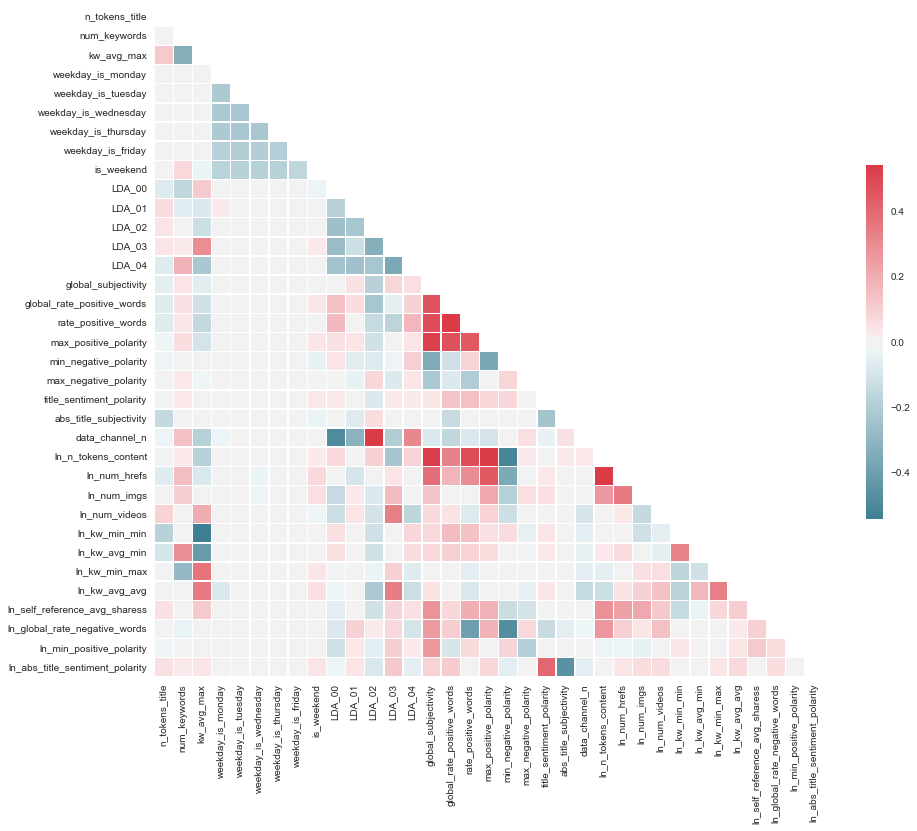

In [50]:
sns.set(style="white")

# Compute the correlation matrix
corr = df.corr()

# Generate a mask for the upper triangle
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(15, 13))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})


# from example found at https://www.kaggle.com/maheshdadhich/strength-of-visualization-python-visuals-tutorial/notebook

#### Save cleaned / reduced data set to external .csv file  

 - This provides opportunity to just read in this .csv file and no need to repeat data cleaning / reduction process for each execution  
 

In [51]:
# ... -=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=
# ... store in ../data/ directory
# ... write as .csv file for future recall
# ... -=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=

data_dir = '../data/'
data_file = 'mashable_clean_dataset_for_lab_02_task_02.csv'

file_2_write = data_dir + data_file

df.to_csv(file_2_write, index = False)


# 	Modeling and Evaluation 2

### Training and test split

In [52]:
# ... -=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=
# ...  copy data frame to classification working data frame
# ... -=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=

# ... data set with text categorical target values 

df_data_channel = df.copy()
del df_data_channel['data_channel_n']

# ... data set with integer categorical target values 

df_data_channel_n = df.copy()
del df_data_channel_n['data_channel']

# ... -=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=
# ...  separate X and y matrices 
# ...
# ...  convert to numpy matrices by calling 'values' on the pandas data frames
# ...  they are now simple matrices for compatibility with scikit-learn
# ... -=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=

if 'data_channel' in df_data_channel:
    y = df_data_channel['data_channel'].values         # set 'data_channel' as dependent
    del df_data_channel['data_channel']                # remove from dataset
    X = df_data_channel.values                         # use everything else for independent EVs

if 'data_channel_n' in df_data_channel_n:
    y_n = df_data_channel_n['data_channel_n'].values    # set 'data_channel' as dependent
    del df_data_channel_n['data_channel_n']             # remove from dataset
    X_n = df_data_channel_n.values                      # use everything else for independent EVs

# ... -=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=
# ...  setup master train and test , golden traina and test
# ...  master sets - first 80% of original data set which will be base training for model building
# ...  Golden sets - 20% of original will be used in the final best model for prediction
# ...  split into training and test sets
# ....  --> 10 folds
# ...   --> 80% / 20% training / test
# ... -=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=




In [53]:
# ... -=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=
# ... Set-up golden test data set
# ... This data-set will be used to evaluate the predictive capability of the final
# ... model on a data set that was not included in any of the prior train/test sets
# ... -=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=

num_cv_iterations = 1
cv_object = ShuffleSplit(n_splits = num_cv_iterations,
                         test_size  = 0.2)
                        
print(cv_object)

for train_indices, test_indices in cv_object.split(X, y):
    master_X_train = X[train_indices]
    master_y_train = y[train_indices]    
    golden_X_test  = X[test_indices]
    golden_y_test  = y[test_indices]
    print(master_X_train.shape)

for train_indices_n, test_indices_n in cv_object.split(X_n, y_n): 
    master_X_train_n = X_n[train_indices_n]
    master_y_train_n = y_n[train_indices_n]    
    golden_X_test_n  = X_n[test_indices_n]
    golden_y_test_n  = y_n[test_indices_n]
    
    
    

ShuffleSplit(n_splits=1, random_state=None, test_size=0.2, train_size=None)
(31715, 34)


In [54]:
# ... -=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=
# ... Set-up training set to be used on 'best' model from grid search results
# ... This data-set will be used to verify 10-fold-CV-model has results consistent
# ... with the model produced from grid search
# ... -=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=

num_cv_iterations = 1
cv_object = ShuffleSplit(n_splits = num_cv_iterations,
                         test_size  = 0.2)
                        
print(cv_object)

for train_indices, test_indices in cv_object.split(master_X_train, master_y_train):
    X_train = master_X_train[train_indices]
    y_train = master_y_train[train_indices]    
    X_test  = master_X_train[test_indices]
    y_test  = master_y_train[test_indices]
    print(X_train.shape)

for train_indices_n, test_indices_n in cv_object.split(master_X_train_n, master_y_train_n): 
    X_train_n = master_X_train_n[train_indices_n]
    y_train_n = master_y_train_n[train_indices_n]    
    X_test_n  = master_X_train_n[test_indices_n]
    y_test_n  = master_y_train_n[test_indices_n]


ShuffleSplit(n_splits=1, random_state=None, test_size=0.2, train_size=None)
(25372, 34)


In [55]:
# set required variables for model comparison

comparison_tbl = pd.DataFrame(columns = [
    'Model Name',
    'Accuracy',
    'Precision',
    'Recall',
    'FScore',
    'Processing Time'])

i_index=[]
i_index = 0

# preparation for cross validation and model comparison, each classifier is appended once model is fit

models = []

# 	Modeling and Evaluation 3	

For task 2 we have chosen the following 4 models:<br>
a. Multinomial logistic regression with parament selection using Grid Search<br>
b. Decision Tree with parament selection using Grid Search<br>
c. Random Forest with parament selection using Grid Search<br>
d. Naive Bayes<br>

Each of these models will be evaluated on Accuracy, Precision, Recall, FScore and Execution time

### a. Multinomial logistic regression
For multinomial LR we have set standard attributes with:
    class_weight = balanced<br>
    multi_class = multinomial<br>
<b>search params:</b><br>
    tolerance parament tol<br>
    Regularization parament C<br>
    
    
#### _Grid selection for logistic regression_

In [56]:
from sklearn.grid_search import GridSearchCV

lr_model = LogisticRegression(
    class_weight = 'balanced',
    multi_class = 'multinomial',
    solver = 'lbfgs',
    C = 10,
    tol = 0.1)

params = {
    'C':[100, 1000], 
    'tol': [0.001, 0.0001]
}

# ... --> changed the scoring on Sat 28-Oct
# ...     - from : log_loss
# ...     - to : neg_log_loss
# ...  (this avoids the deprecation warning)

clf = GridSearchCV(
    lr_model,
    params,
    scoring = 'neg_log_loss',
    refit = 'True',
    n_jobs = -1,
    cv = 5)

grid_search = clf.fit(master_X_train, master_y_train)

best_accuracy = grid_search.best_score_
best_parameters = grid_search.best_params_

#### _Best parameter values for logistic regression_:

In [57]:
best_accuracy
best_parameters

-0.7544798733585832

{'C': 1000, 'tol': 0.001}

#### Create main logistic model using best paraments for further analysis and model comparisons

In [58]:
tic = time.clock()

# ... -=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=
# ... basic multiclass Logistic Regression
# ... - normalize features based on mean & stdev of each column
# ... -=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=

lr_model1 = LogisticRegression(
    class_weight = 'balanced',
    multi_class = 'multinomial',
    solver = 'lbfgs',
    C = 100,
    tol = 0.001)

lr_model1.fit(X_train, y_train)  # train object

y_hat = lr_model1.predict(X_test) # get test set precitions

toc =  time.clock()

# calculate statistics

accuracy = '{0:.4f}'.format(metrics.accuracy_score(y_test, y_hat))
precision = '{0:.4f}'.format(metrics.precision_score(y_test, y_hat,average='weighted'))
recall = '{0:.4f}'.format(metrics.recall_score(y_test, y_hat,average='weighted'))
f1_score = '{0:.4f}'.format(metrics.f1_score(y_test, y_hat,average='weighted'))

exetime = '{0:.4f}'.format(toc-tic)

# print statistics

print("accuracy",accuracy )
print("precision",precision )
print("recall",recall )
print("f1_score",f1_score )
print("confusion matrix\n", conf(y_test, y_hat))
print('process time',exetime)
print("\n")

# save statistics for model comparison

raw_data = {
    'Model Name' : 'Logistic Regression',
    'Accuracy' : accuracy,
    'Precision' : precision,
    'Recall' : recall,
    'FScore' : f1_score,
    'Processing Time' : exetime
}

df_tbl = pd.DataFrame(raw_data,
    columns = ['Model Name', 'Accuracy', 'Precision', 'Recall', 'FScore', 'Processing Time'],
    index = [i_index + 1])

comparison_tbl = comparison_tbl.append(df_tbl)

#append model classifier for cross-validation

models.append(('Logistic Regression', lr_model1))


LogisticRegression(C=100, class_weight='balanced', dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='multinomial', n_jobs=1, penalty='l2',
          random_state=None, solver='lbfgs', tol=0.001, verbose=0,
          warm_start=False)

accuracy 0.7172
precision 0.7451
recall 0.7172
f1_score 0.7279
confusion matrix
 [[ 778   17   44   10  133   37   18]
 [   8  824   26  188   42   11   42]
 [  22    7  160   15   29  101    8]
 [  16  131   20  779   19    2   11]
 [  69   17   45   33  155   11   43]
 [  28   17  263    6   23  775   49]
 [  15   35   38   28   50   67 1078]]
process time 4.1552




### b. Decision Tree Classifier using Grid Search
#### _Grid search parameter set-up_

In [59]:
# Applying Grid Search to find the best model and the best parameters

from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV

DTclassifier = DecisionTreeClassifier(criterion = 'entropy', random_state = 0)

parameters = [
      {
        'criterion': ['gini'], 
        'max_depth': [None], 
        'min_samples_split': [2, 100, 1000], 
        'min_samples_leaf': [1, 10, 100],
        'max_features': [None], 'max_leaf_nodes': [None]
      },
      {
          'criterion': ['entropy'], 
          'max_depth': [None, 5, 10], 
          'min_samples_split': [2, 100, 1000],
          'min_samples_leaf': [1, 10, 100], 
          'max_leaf_nodes': [None]
      }
     ]

grid_search = GridSearchCV(estimator = DTclassifier,
                           param_grid = parameters,
                           scoring = 'accuracy',
                           cv = 5,
                           n_jobs = -1)

grid_search = grid_search.fit(master_X_train, master_y_train)

best_accuracy = grid_search.best_score_
best_parameters = grid_search.best_params_


#### _Best parameters for Decision Tree_

In [60]:
best_accuracy
best_parameters

0.76178464448998895

{'criterion': 'gini',
 'max_depth': None,
 'max_features': None,
 'max_leaf_nodes': None,
 'min_samples_leaf': 10,
 'min_samples_split': 100}

#### _use best parameters to create best Decision Tree model for further analysis and model comparison_

In [61]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import confusion_matrix,classification_report

tic = time.clock()

# train and fit

DTclassifier = DecisionTreeClassifier(
    criterion = 'gini',
    min_samples_leaf = 10,
    min_samples_split = 100)

DTclassifier.fit(X_train, y_train)
y_predDT = DTclassifier.predict(X_test)

# calculate statistics

accuracy = '{0:.4f}'.format(metrics.accuracy_score(y_test, y_predDT))
precision = '{0:.4f}'.format(metrics.precision_score(y_test, y_predDT,average='weighted'))
recall = '{0:.4f}'.format(metrics.recall_score(y_test, y_predDT,average='weighted'))
f1_score = '{0:.4f}'.format(metrics.f1_score(y_test, y_predDT,average='weighted'))
toc =  time.clock()
exetime = '{0:.4f}'.format(toc-tic)

# print statistics
print("accuracy",accuracy )
print("precision",precision )
print("recall",recall )
print("f1_score",f1_score )
print("confusion matrix\n", confusion_matrix(y_test, y_predDT))
print('process time',exetime)
print("\n")

# save statistics for model comparison

raw_data = {
    'Model Name':'Decision Tree Classifier',
    'Accuracy':accuracy,
    'Precision':precision,
    'Recall':recall,
    'FScore':f1_score,
    'Processing Time': exetime
}

df_tbl = pd.DataFrame(raw_data,
        columns = ['Model Name','Accuracy','Precision','Recall','FScore','Processing Time'],
        index = [i_index + 1])

comparison_tbl = comparison_tbl.append(df_tbl)

#append model classifier for cross-validation

models.append(('Decision Tree Classifier', DTclassifier))


DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=10, min_samples_split=100,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')

accuracy 0.7634
precision 0.7478
recall 0.7634
f1_score 0.7515
confusion matrix
 [[ 880   24   10   11   41   42   29]
 [  17  889    3  164   14   21   33]
 [  32   12   80   26   22  160   10]
 [  16  110   13  814    5    6   14]
 [  99   35   22   30  102   27   58]
 [  42   28   53   12    6  950   70]
 [  21   42    2   23   24   72 1127]]
process time 0.7710




### c. Random Forest Classifier

#### _Grid Search parameter set-up for Random Forest classifier_

In [64]:
RFclf = RandomForestClassifier(
    criterion = 'entropy',
    max_features= 'sqrt',
    max_depth = 5,
    n_estimators = 10,
    n_jobs = -1)

#RFclf.fit(master_X_train, master_y_train)

param_grid =[
    { 
    'criterion': ['gini'],
    'n_estimators': [100, 500],
    'max_features': ['auto', 'sqrt', 'log2'],
    'max_depth': [10, 20, 50]
},
 { 
    'criterion': ['entropy'],
    'n_estimators': [100, 500],
    'max_features': ['auto', 'sqrt', 'log2'],
    'max_depth': [10, 20, 50]
}
]

RF_grid_search = GridSearchCV(
    estimator = RFclf,
    param_grid = param_grid,
    cv = 2)

grid_search = RF_grid_search.fit(master_X_train, master_y_train)

best_accuracy = grid_search.best_score_
best_parameters = grid_search.best_params_

best_criterion = best_parameters['criterion']
best_max_depth = best_parameters['max_depth']
best_max_features = best_parameters['max_features']
best_n_estimators = best_parameters['n_estimators']


#### _best parameters for Random Forest Classifier_

In [66]:
best_accuracy
best_parameters

0.80230174996058645

{'criterion': 'entropy',
 'max_depth': 50,
 'max_features': 'auto',
 'n_estimators': 500}

#### _using best parameters for main model for further analysis and model comparison_

In [67]:
from sklearn.ensemble import RandomForestClassifier

tic = time.clock()

# train and test 

RFclf = RandomForestClassifier(
    criterion = best_criterion,
    max_depth = best_max_depth,
    max_features = best_max_features,
    n_estimators = best_n_estimators,
    n_jobs = -1)

RFclf.fit(X_train, y_train)
y_predRF = RFclf.predict(X_test)

# calculate statistics

accuracy = '{0:.4f}'.format(metrics.accuracy_score(y_test, y_predRF))
precision = '{0:.4f}'.format(metrics.precision_score(y_test, y_predRF, average ='weighted'))
recall = '{0:.4f}'.format(metrics.recall_score(y_test, y_predRF, average = 'weighted'))
f1_score = '{0:.4f}'.format(metrics.f1_score(y_test, y_predRF, average = 'weighted'))
toc =  time.clock()
exetime = '{0:.4f}'.format(toc-tic)

# print statistics
print("accuracy",accuracy )
print("precision",precision )
print("recall",recall )
print("f1_score",f1_score )
print("confusion matrix\n", confusion_matrix(y_test, y_predRF))
print('process time',exetime)
print("\n")


# save statistics for model comparison

raw_data = {
    'Model Name':'Random Forest Classifier',
    'Accuracy':accuracy,
    'Precision':precision,
    'Recall':recall,
    'FScore':f1_score,
    'Processing Time': exetime
}

df_tbl = pd.DataFrame(raw_data,
        columns = ['Model Name','Accuracy','Precision','Recall','FScore','Processing Time'],
        index = [i_index + 1])

comparison_tbl = comparison_tbl.append(df_tbl)

#append model classifier for cross-validation

models.append(('Random Forest Classifier', RFclf))


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='entropy',
            max_depth=100, max_features='sqrt', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=700, n_jobs=-1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

accuracy 0.8061
precision 0.8021
recall 0.8061
f1_score 0.7858
confusion matrix
 [[ 935   14    0   10    8   38   32]
 [  19  939    0  128    3   27   25]
 [  40    9   38   25   12  208   10]
 [  13   48    5  891    0    3   18]
 [  92   32    5   27  126   38   53]
 [  40   19    8    9    8 1030   47]
 [  25   37    1   23    5   66 1154]]
process time 222.4900




RandomForestClassifier(bootstrap=True, class_weight=None, criterion='entropy',
            max_depth=100, max_features='sqrt', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=700, n_jobs=-1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)


<Container object of 34 artists>

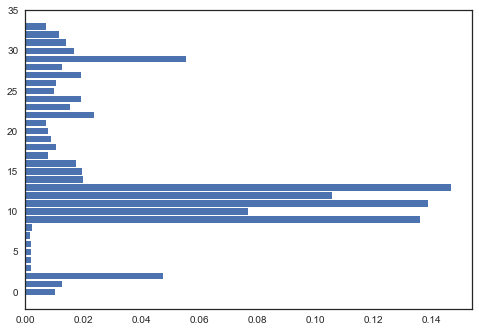

In [68]:
print (RFclf)
plt.barh(range(len(RFclf.feature_importances_)), RFclf.feature_importances_)
plt.show()

#  3: Naive Bayes ***


In [70]:
from sklearn.naive_bayes import MultinomialNB

MNBclf = MultinomialNB(
    alpha = 0.01,
    class_prior = None,
    fit_prior = True)

params = {
    'alpha':[0.1, 0.5, 1.0]
}

MNB_grid_search = GridSearchCV(
    MNBclf,
    params,
    cv = 5)

grid_search = MNB_grid_search.fit(master_X_train, master_y_train)

best_accuracy = grid_search.best_score_
best_parameters = grid_search.best_params_

best_accuracy
best_parameters

best_alpha = best_parameters['alpha']

0.64105312943402171

{'alpha': 0.1}

In [76]:
tic = time.clock()

# train and test 

MNBclf = MultinomialNB(
    alpha = best_alpha,
    class_prior = None,
    fit_prior = True)

MNBclf.fit(X_train, y_train)
y_predMNB = MNBclf.predict(X_test)

# calculate statistics

accuracy = '{0:.4f}'.format(metrics.accuracy_score(y_test, y_predMNB))
precision = '{0:.4f}'.format(metrics.precision_score(y_test, y_predMNB, average ='weighted'))
recall = '{0:.4f}'.format(metrics.recall_score(y_test, y_predMNB, average = 'weighted'))
f1_score = '{0:.4f}'.format(metrics.f1_score(y_test, y_predMNB, average = 'weighted'))
toc =  time.clock()
exetime = '{0:.4f}'.format(toc-tic)

# print statistics
print("accuracy",accuracy )
print("precision",precision )
print("recall",recall )
print("f1_score",f1_score )
print("confusion matrix\n", confusion_matrix(y_test, y_predMNB))
print('process time',exetime)
print("\n")


# save statistics for model comparison

raw_data = {
    'Model Name':'Multinomial Naïve Bayes',
    'Accuracy':accuracy,
    'Precision':precision,
    'Recall':recall,
    'FScore':f1_score,
    'Processing Time': exetime
}

df_tbl = pd.DataFrame(raw_data,
        columns = ['Model Name','Accuracy','Precision','Recall','FScore','Processing Time'],
        index = [i_index + 1])

comparison_tbl = comparison_tbl.append(df_tbl)

#append model classifier for cross-validation

models.append(('Multinomial Naïve Bayes', MNBclf))


MultinomialNB(alpha=0.1, class_prior=None, fit_prior=True)

accuracy 0.6372
precision 0.6081
recall 0.6372
f1_score 0.6172
confusion matrix
 [[ 724   32   51   22   33   91   84]
 [  21  674   34  223   10   95   84]
 [  42    9   30   28    2  189   42]
 [  21  205   27  657    9   29   30]
 [ 112   51   21   44   19   53   73]
 [  69   25   27   23    2  868  147]
 [  23   31   25   21   24  117 1070]]
process time 0.3293




In [77]:
from sklearn.naive_bayes import GaussianNB

tic = time.clock()

# train and test 

GNBclf = GaussianNB()

GNBclf.fit(X_train, y_train)
y_predGNB = GNBclf.predict(X_test)

# calculate statistics

accuracy = '{0:.4f}'.format(metrics.accuracy_score(y_test, y_predGNB))
precision = '{0:.4f}'.format(metrics.precision_score(y_test, y_predGNB, average ='weighted'))
recall = '{0:.4f}'.format(metrics.recall_score(y_test, y_predGNB, average = 'weighted'))
f1_score = '{0:.4f}'.format(metrics.f1_score(y_test, y_predGNB, average = 'weighted'))
toc =  time.clock()
exetime = '{0:.4f}'.format(toc-tic)

# print statistics
print("accuracy",accuracy )
print("precision",precision )
print("recall",recall )
print("f1_score",f1_score )
print("confusion matrix\n", confusion_matrix(y_test, y_predGNB))
print('process time',exetime)
print("\n")


# save statistics for model comparison

raw_data = {
    'Model Name':'Gaussian Naïve Bayes',
    'Accuracy':accuracy,
    'Precision':precision,
    'Recall':recall,
    'FScore':f1_score,
    'Processing Time': exetime
}

df_tbl = pd.DataFrame(raw_data,
        columns = ['Model Name','Accuracy','Precision','Recall','FScore','Processing Time'],
        index = [i_index + 1])

comparison_tbl = comparison_tbl.append(df_tbl)

#append model classifier for cross-validation

models.append(('Gaussian Naïve Bayes', GNBclf))

GaussianNB(priors=None)

accuracy 0.7195
precision 0.7089
recall 0.7195
f1_score 0.7131
confusion matrix
 [[ 823   19   27    4   76   54   34]
 [  14  865   14  179   25   19   25]
 [  47    3   77   19    7  178   11]
 [   5  200   29  700   35    1    8]
 [ 136   32   28   26   81   25   45]
 [  44   17   90    4   19  930   57]
 [  25   51    6   25   36   80 1088]]
process time 0.1708




#	Modeling and Evaluation 4

In [78]:
# converting acc, pre, recall, fscore and time to numeric values for plots

comparison_tbl = comparison_tbl.reset_index(drop=True)
comparison_tbl['Precision'] = pd.to_numeric(comparison_tbl['Precision'])
comparison_tbl['Accuracy'] = pd.to_numeric(comparison_tbl['Accuracy'])
comparison_tbl['FScore']= pd.to_numeric(comparison_tbl['FScore'])
comparison_tbl['Processing Time'] = pd.to_numeric(comparison_tbl['Processing Time'])
comparison_tbl['Recall'] = pd.to_numeric(comparison_tbl['Recall'])
comparison_tbl


,Model Name,Accuracy,Precision,Recall,FScore,Processing Time
0,Logistic Regression,0.7172,0.7451,0.7172,0.7279,4.1552
1,Decision Tree Classifier,0.7634,0.7478,0.7634,0.7515,0.7710
2,Random Forest Classifier,0.8061,0.8021,0.8061,0.7858,222.4900
3,Multinomial Naïve Bayes,0.6372,0.6081,0.6372,0.6172,0.3293
4,Gaussian Naïve Bayes,0.7195,0.7089,0.7195,0.7131,0.1708


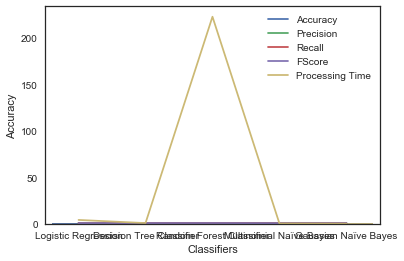

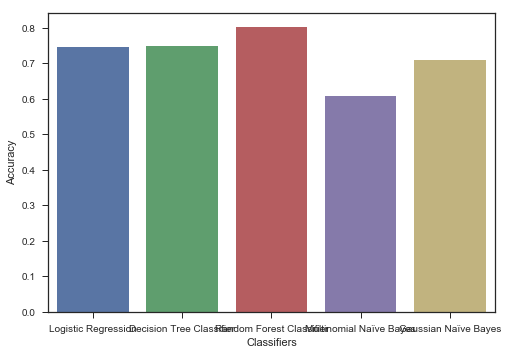

In [79]:
from pylab import rcParams
%matplotlib inline

comparison_tbl.plot()

rcParams['figure.figsize'] = 8, 5
sns.set(style="ticks")
sns.barplot(data=comparison_tbl,y='Accuracy',x='Model Name')
plt.xlabel('Classifiers')
plt.ylabel('Accuracy')
plt.show()

sns.barplot(data=comparison_tbl,y='Precision',x='Model Name')
plt.xlabel('Classifiers')
plt.ylabel('Accuracy')
plt.show()



# 10-K Cross-Validation for each classifier
For each classifier we run 10 fold cross validation which will help us narrow down one final model

In [81]:
from sklearn import model_selection

# evaluate each model in turn

results = []
names = []
scoring = 'accuracy'

for name, model in models:
    cv_results = model_selection.cross_val_score(
        model,
        master_X_train,
        master_y_train,
        cv = 10,
        scoring = scoring)
    results.append(cv_results)
    names.append(name)
    msg = "\n\t%50s: %.3f (%.4f)\n\n" % (name, cv_results.mean(), cv_results.std())
    print(cv_results)
    print(msg)

[ 0.72040302  0.71707624  0.72257251  0.7127995   0.71775465  0.72343109
  0.72618297  0.72302839  0.7192429   0.72041654]

	                               Logistic Regression: 0.720 (0.0036)
[ 0.76133501  0.76937618  0.77238335  0.75819672  0.75528225  0.77041943
  0.75772871  0.76782334  0.75015773  0.76585674]

	                          Decision Tree Classifier: 0.763 (0.0070)
[ 0.8145466   0.80749842  0.81462799  0.80706179  0.80258594  0.81456954
  0.80473186  0.81135647  0.80599369  0.81255917]

	                          Random Forest Classifier: 0.810 (0.0043)
[ 0.64168766  0.64650284  0.64501892  0.65794451  0.63513087  0.63103122
  0.64132492  0.63753943  0.63312303  0.64342064]

	                           Multinomial Naïve Bayes: 0.641 (0.0074)
[ 0.72134761  0.72243226  0.72572509  0.71595208  0.71018606  0.72248502
  0.72712934  0.72397476  0.71514196  0.71946986]

	                              Gaussian Naïve Bayes: 0.720 (0.0050)


{'boxes': [<matplotlib.lines.Line2D at 0x7f39203fb0f0>,
 'caps': [<matplotlib.lines.Line2D at 0x7f39203dc7b8>,
 'fliers': [<matplotlib.lines.Line2D at 0x7f39203f2e48>,
 'means': [],
 'medians': [<matplotlib.lines.Line2D at 0x7f39203aa630>,
 'whiskers': [<matplotlib.lines.Line2D at 0x7f39203fbb70>,
  <matplotlib.lines.Line2D at 0x7f39203a39b0>]}

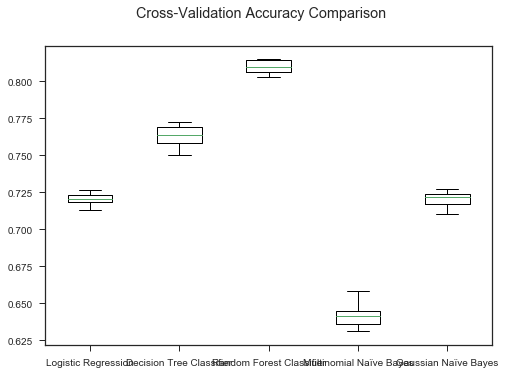

In [82]:
# boxplot accuracy comparison

fig = plt.figure()
fig.suptitle('Cross-Validation Accuracy Comparison')
ax = fig.add_subplot(111)

plt.boxplot(results)

ax.set_xticklabels(names)
plt.show()


#### Golden test data set prediction with our final model

our final best model is Random Forest Classifier. We will run prediction on that fit with the test data set we set aside at the beggining of the project. We will calculate statistics for the prediction.

In [83]:
y_predFinal = RFclf.predict(golden_X_test)

# calculate statistics

accuracy = '{0:.4f}'.format(metrics.accuracy_score(golden_y_test, y_predFinal))
precision = '{0:.4f}'.format(metrics.precision_score(golden_y_test, y_predFinal, average ='weighted'))
recall = '{0:.4f}'.format(metrics.recall_score(golden_y_test, y_predFinal, average = 'weighted'))
f1_score = '{0:.4f}'.format(metrics.f1_score(golden_y_test, y_predFinal, average = 'weighted'))
toc =  time.clock()
exetime = '{0:.4f}'.format(toc-tic)

# print statistics
print("accuracy", accuracy )
print("precision", precision )
print("recall", recall )
print("f1_score", f1_score )
print("confusion matrix\n", confusion_matrix(y_test, y_predRF))
print('process time', exetime)
print("\n")


accuracy 0.8140
precision 0.8119
recall 0.8140
f1_score 0.7954
confusion matrix
 [[ 935   14    0   10    8   38   32]
 [  19  939    0  128    3   27   25]
 [  40    9   38   25   12  208   10]
 [  13   48    5  891    0    3   18]
 [  92   32    5   27  126   38   53]
 [  40   19    8    9    8 1030   47]
 [  25   37    1   23    5   66 1154]]
process time 2590.4913




# 	Exceptional Work	
We have implemented Grid search in our parament selection process.